<a href="https://colab.research.google.com/github/patlewig/aim/blob/master/notebooks/fingerprint_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import date
today = date.today()
day = today.strftime("%m_%d_%y")
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import openpyxl
%matplotlib inline

#### Author: Matthew Adams
#### Principal Investigator: Grace Patlewicz
#### Last Modified Sept 28 2022

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
processed_dir = TOP + 'data/processed/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'
refs_dir = TOP + 'references/'

## Build Confusion Matrix

Inputs:
- 2 fingerprint files from CORINA (.txt format) read as df objects
    - Input needed for CORINA:
        - TOXPRINT_SUPERSET.smi file 
        - AIM.xml file (set 1)
        - Toxprints.xml file (set 2)
    
- Remove any errors and non-fingerprint columns before building matrix


Outputs:

- Pickle file of confusion matrix dataframe


<div class="alert alert-info">

**Note:** It will take about an hour to build a new matrix

</div>

In [3]:
from collections import Counter

df_toxprints = pd.read_csv(raw_dir+'toxprint_output.txt', sep=';')
df_toxprints = df_toxprints[df_toxprints['M_CORINA_SYMPHONY_ERRORS_[STRING]'] == 'No errors']
df_1 = df_toxprints.iloc[:,1:-2]

# Due to the way that the AIM CSRML file was created, 
#there are duplicate subgraphs acting as a single fingerprint 
# that must be combined into one column before running 

df_aim = pd.read_csv(raw_dir+'aim_output.txt', sep=';')
df_aim = df_aim[df_aim['M_CORINA_SYMPHONY_ERRORS_[STRING]'] == 'No errors']
df_0 = df_aim.iloc[:,1:-2]

def clean_aim_df(df_0):
    """
    combines duplicate columns in aim fragment fp dataframe
        Args: 
            df_0, dataframe object
    
        Returns: 
            df_0, dataframe, object
        """
    col_names = []
    for i in df_0.columns:
        col_names.append(i.split('.')[0])    
    mylist = Counter(col_names)
    duplicate_list= {key: value for key, value in mylist.items() if value > 1}

    len_dict = len(duplicate_list)
    sum_dict = sum(duplicate_list.values())
    print(f'{sum_dict-len_dict} columns to be removed')

    cols = []
    for i in df_0.columns:
        if i.split('.')[0] in duplicate_list.keys():
            cols.append(i)

    df_dupes = df_0[cols].copy()
    for i,col in enumerate(df_dupes):
        col_1 = df_dupes.iloc[:,i].name.split('.')[0]
        for j, col2 in enumerate(df_dupes):
            col_2 = df_dupes.iloc[:,j].name.split('.')[0]
            if col_1 == col_2:
                df_dupes[col] = df_dupes[[col,col2]].max(axis=1)



    n_before = df_0.shape[1]
    for col in df_dupes:
        if len(col.split('.')) >= 2:
            if col.split('.')[1].isdigit() == True:
                df_0 = df_0.drop(columns=[col])
            elif col.split('.')[1].isdigit() == False:
                if len(col.split('.')) > 2:
                    df_0 = df_0.drop(columns=[col])
        else:
            df_0[col] = df_dupes[col]


    df_0
    n_after = df_0.shape[1]

    print(f'{n_before-n_after} columns removed')
    return df_0
    
df_0 = clean_aim_df(df_0)

85 columns to be removed
85 columns removed


In [4]:
def build_comparison_matrix(df_0,df_1,filename="pickled_df"):
    """
    Builds a comparison matrix
    
    Args:
        df_0 (object):
        df_1 (object):
        filename (str):
    Returns:
        df_2 (object):
    """
    df_2 = pd.DataFrame(columns = [df_0.columns], index=[df_1.columns])
    for i, col in enumerate(df_0):
        a = []
        for j, col in enumerate(df_1):
            df_cross = pd.crosstab(df_0.iloc[:,i],df_1.iloc[:,j], dropna=False)[::-1]
            #print(df_cross)
            if df_cross.shape[1] == 1:
                df_cross['1'] = 0

            df_cross = df_cross[df_cross.columns[::-1]]
            df_cross = df_cross.transpose()

            if df_cross.shape[1] == 1:
                df_cross.insert(0,'1',0)
            
            a.append(df_cross.to_numpy())

        df_2.iloc[:,i] = a

    df_2.pickle.dump(processed_dir+f"{filename}_{day}.pkl")
    return df_2

In [5]:
df_2 = pickle.load( open( processed_dir+"aim_tox_clean_compare.pkl", "rb" ) )

In [6]:
# Read a previously built confusion matrix
#df_2 = pd.read_pickle(processed_dir+'aim_tox_clean_compare.pkl')
df_2.shape

(729, 783)

In [7]:
df_2.head()

,CH3 [aliphatic carbon],CH2 [aliphatic carbon],CH [aliphatic carbon],"C [aliphatic carbon No H, not tert]",=CH2 [olefinic carbon],=CH or =C [olefinc carbon],#C [acetylenic carbon],"OH [hydroxy, aliphatic attach]","O [oxygen, aliphatic attach]",NH2 [aliphatic attach],...,N CH=N OH [oxime type] correction,Ring rx: OH ortho to C=N N carbon,=C (C#N) C#N [dicyano] correction,Aromatic nitrogen C C(=S) N struct corr.,Cyclic ketoxime(>C=N OH) [1 olefin attach],C=N O sulfur(aliphatic) [iminoxy] correc,S N( C(=O) C) C(=O) C struct correction,Sulfur(+4) charged halide type,Ring rx: S=P(O)(O)O / 5 mem (2 nitrogen),O=P( O)( O) C OH correction
atom:element_main_group,"[[0, 274], [16570, 9065]]","[[0, 274], [16188, 9447]]","[[0, 274], [7787, 17848]]","[[0, 274], [2444, 23191]]","[[0, 274], [1336, 24299]]","[[0, 274], [5065, 20570]]","[[1, 273], [217, 25418]]","[[0, 274], [3530, 22105]]","[[0, 274], [2904, 22731]]","[[0, 274], [1741, 23894]]",...,"[[0, 274], [14, 25621]]","[[0, 274], [3, 25632]]","[[0, 274], [16, 25619]]","[[0, 274], [0, 25635]]","[[0, 274], [2, 25633]]","[[0, 274], [8, 25627]]","[[0, 274], [3, 25632]]","[[0, 274], [0, 25635]]","[[0, 274], [2, 25633]]","[[0, 274], [2, 25633]]"
atom:element_metal_group_I_II,"[[1225, 1718], [15345, 7621]]","[[1078, 1865], [15110, 7856]]","[[500, 2443], [7287, 15679]]","[[268, 2675], [2176, 20790]]","[[63, 2880], [1273, 21693]]","[[342, 2601], [4723, 18243]]","[[6, 2937], [212, 22754]]","[[217, 2726], [3313, 19653]]","[[186, 2757], [2718, 20248]]","[[92, 2851], [1649, 21317]]",...,"[[1, 2942], [13, 22953]]","[[0, 2943], [3, 22963]]","[[0, 2943], [16, 22950]]","[[0, 2943], [0, 22966]]","[[0, 2943], [2, 22964]]","[[1, 2942], [7, 22959]]","[[0, 2943], [3, 22963]]","[[0, 2943], [0, 22966]]","[[0, 2943], [2, 22964]]","[[0, 2943], [2, 22964]]"
atom:element_metal_group_III,"[[24, 210], [16546, 9129]]","[[10, 224], [16178, 9497]]","[[6, 228], [7781, 17894]]","[[4, 230], [2440, 23235]]","[[0, 234], [1336, 24339]]","[[3, 231], [5062, 20613]]","[[0, 234], [218, 25457]]","[[2, 232], [3528, 22147]]","[[0, 234], [2904, 22771]]","[[0, 234], [1741, 23934]]",...,"[[0, 234], [14, 25661]]","[[0, 234], [3, 25672]]","[[0, 234], [16, 25659]]","[[0, 234], [0, 25675]]","[[0, 234], [2, 25673]]","[[0, 234], [8, 25667]]","[[0, 234], [3, 25672]]","[[0, 234], [0, 25675]]","[[0, 234], [2, 25673]]","[[0, 234], [2, 25673]]"
atom:element_metal_metalloid,"[[774, 493], [15796, 8846]]","[[597, 670], [15591, 9051]]","[[127, 1140], [7660, 16982]]","[[38, 1229], [2406, 22236]]","[[92, 1175], [1244, 23398]]","[[121, 1146], [4944, 19698]]","[[6, 1261], [212, 24430]]","[[44, 1223], [3486, 21156]]","[[300, 967], [2604, 22038]]","[[35, 1232], [1706, 22936]]",...,"[[1, 1266], [13, 24629]]","[[0, 1267], [3, 24639]]","[[0, 1267], [16, 24626]]","[[0, 1267], [0, 24642]]","[[0, 1267], [2, 24640]]","[[0, 1267], [8, 24634]]","[[0, 1267], [3, 24639]]","[[0, 1267], [0, 24642]]","[[0, 1267], [2, 24640]]","[[0, 1267], [2, 24640]]"
atom:element_metal_poor_metal,"[[218, 309], [16352, 9030]]","[[188, 339], [16000, 9382]]","[[57, 470], [7730, 17652]]","[[6, 521], [2438, 22944]]","[[5, 522], [1331, 24051]]","[[39, 488], [5026, 20356]]","[[0, 527], [218, 25164]]","[[14, 513], [3516, 21866]]","[[15, 512], [2889, 22493]]","[[3, 524], [1738, 23644]]",...,"[[0, 527], [14, 25368]]","[[0, 527], [3, 25379]]","[[0, 527], [16, 25366]]","[[0, 527], [0, 25382]]","[[0, 527], [2, 25380]]","[[0, 527], [8, 25374]]","[[0, 527], [3, 25379]]","[[0, 527], [0, 25382]]","[[0, 527], [2, 25380]]","[[0, 527], [2, 25380]]"



## Plotting the distributions
We want to look at the overall distribution of the Fragments across the data space

285.6373801916933


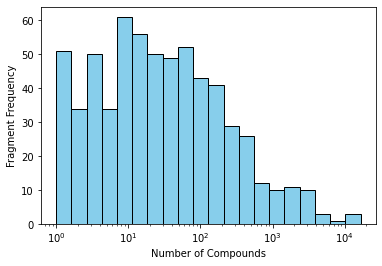

In [8]:
df_1_sums = df_1.sum(numeric_only=True,axis=0)
df_0_sums = df_0.sum(numeric_only=True,axis=0)

def plot_loghist(x, bins,color, filename):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins,color=color,edgecolor='black',linewidth='1')
    plt.ylabel('Fragment Frequency')
    plt.xlabel('Number of Compounds')
    plt.xscale('log')
    plt.savefig(figures_dir+filename, dpi = 300)
x = np.array(df_0_sums)
x = x[x!=0]
print(x.mean())

#plt.title('AIM Fragments')
plot_loghist(x, 20,'skyblue', 'Figure4.png')



454.42587209302326


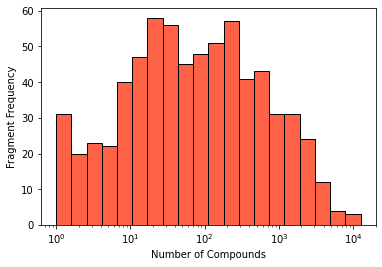

In [9]:

x = np.array(df_1_sums)
x = x[x!=0]
print(x.mean())

#plt.title('Toxprints')
plot_loghist(x, 20,'tomato', 'Figure4b.png')

In [10]:
# Manual test to check that the confusion matrix was built properly...

i = 1
j = 4

df_temp = pd.merge(df_0.iloc[:,i],df_1.iloc[:,j],left_index=True,right_index=True)


TP = df_temp[(df_temp != 0).all(1)].shape[0]  #n rows which both features show up
TN = (df_temp.shape[0] - df_temp[(df_temp != 0).any(1)].shape[0]) # n rows which neither show
FP = sum(df_temp[df_temp.iloc[:,0] == 0].iloc[:,1]) #n rows where only TOX feature
FN = sum(df_temp[df_temp.iloc[:,1] == 0].iloc[:,0]) #n rows where only AIM feature

print(df_2.iloc[:,i].name[0])
print(df_2.iloc[j,:].name[0])
print(np.reshape(df_2.iloc[j,i],(4,)).tolist())

print(df_0.iloc[:,i].name)
print(df_1.iloc[:,j].name)
print([TP,FP,FN,TN])


print(sum(df_0.iloc[:,i]),(TP+FN),df_0.iloc[:,i].name)
print(sum(df_1.iloc[:,j]),(TP+FP),df_1.iloc[:,j].name)

# [Tox+AIM,TOX_only,AIM_only,None]



 CH2 [aliphatic carbon]
atom:element_metal_poor_metal
[188, 339, 16000, 9382]
 CH2 [aliphatic carbon]
atom:element_metal_poor_metal
[188, 339, 16000, 9382]
16188 16188  CH2 [aliphatic carbon]
527 527 atom:element_metal_poor_metal


## Direct Comparison of Individual Fragments in each Set

We want to see if there is a existing toxprint that already captures the same features as an aim fragment

To do that we can use Jaccard similarity index to see how their preseence overlaps in the chemical space

In [12]:
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt

# Filter dataframe - what if the fragments don't show up at all in the structure (No FN or TP)
# AIM:Toxprint to see there is a existing toxprint that already captures the same features as an aim fragment
#then do Toxprint:AIM to see if there are aim fragments that match respective toxprints

def fragment_compare(df,coln,transpose=False):
    """Description goes here.
    
    Args: 
        df (object):
        coln (int):
        transpose (bool):
        
    Returns: 
        df2 (object):
    
    """
    if transpose==True:
        df = df.T
    df1 = df.iloc[:,coln]
    df2= df1.apply(lambda x: np.reshape(x,(4,)).tolist())
    df2 = pd.DataFrame(df2).reset_index()
    df2.columns = ['Fragment Name', 'Count']
    df2.index.name = df1.name
    df2[['TP','FP','FN','TN']] = pd.DataFrame(df2.Count.tolist(),index=df2.index)
    df2['(TP+FP+FN)'] = df2[['TP','FP','FN']].sum(axis=1)
    df2['FP/(TP+FP+FN) (Tox Only)'] = df2['FP'].div(df2['(TP+FP+FN)'])
    df2['TP/(TP+FP+FN) (Jaccard)'] = df2['TP'].div(df2['(TP+FP+FN)'])
    df2['FN/(TP+FP+FN) (AIM Only)'] = df2['FN'].div(df2['(TP+FP+FN)'])

    return df2

def most_alike(df,col_name,transpose=False):
    """Description goes here.
    
    Args: 
        df (object):
        col_name (str):
        transpose (bool):
    Returns: 
        comp_info (dict):
    
    """
    df = df.sort_values(by=[col_name], ascending=False, key= lambda col: col.map(lambda x: x))
    AIM_name = str(df.index.name).strip("('',)")
    toxprint_name = df.iloc[0,0]
    attribute = df[col_name].loc[df[col_name].idxmax()]
    comp_info = {AIM_name + "; " + toxprint_name:[attribute]}
    #print(comp_info)
    return comp_info

def plot_comparison(df,col_name,filename,transpose=False):
    """Description goes here.
    
    Args: 
        df (object):
        col_name (str):
        filename (str):
        transpose (bool):
        
    Returns: 
        
    """
    max_dict = {}
    skipped = 0
    for i in range(df.shape[transpose==False]):
        df2 = fragment_compare(df,i,transpose)
        if transpose==False:
            df2 = df2[(df2['FN'] > 0) | (df2['TP'] > 0)]
        else:
            df2 = df2[(df2['FP'] > 0) | (df2['TP'] > 0)]
        if df2.shape[0] == 0:
            skipped+=1
            continue
        max_dict.update(most_alike(df2,col_name,transpose))

    print("Skipped due to no presence within dataset:",skipped)
    pd.set_option('display.max_rows', 10) #Change to 'None' to show all rows
    pd.set_option('display.max_colwidth', None)

    max_df = pd.DataFrame.from_dict(max_dict, orient='index', columns=[col_name])
    max_df.reset_index(inplace=True)
    max_df = max_df.rename(columns={"index":"AIM:Toxprint Pair"})
    
    
    X = max_df.iloc[:,1]
    print(X.mean())
    print(X.shape)
    #print(max_df.head())
    if transpose==False:
        plt.title('AIM-CSRML:Tox')
        color = 'lightblue'
    else:
        plt.title('TOX:AIM-CSRML')
        color='tomato'
        
    plt.rcParams.update({'font.size':18})
    plt.yticks(np.arange(0,350,50))
    plt.ylim(0,350)
    plt.ylabel('N pairs')
    plt.xlabel('Max(Jaccard(AIM-CSRML,Tox))')
    n,bins,patches = plt.hist(X,bins=10,color=color,edgecolor='black',linewidth=1)
    plt.savefig(figures_dir+'Figure5.png', dpi = 300, bbox_inches = 'tight')



In [14]:
df_2

,CH3 [aliphatic carbon],CH2 [aliphatic carbon],CH [aliphatic carbon],"C [aliphatic carbon No H, not tert]",=CH2 [olefinic carbon],=CH or =C [olefinc carbon],#C [acetylenic carbon],"OH [hydroxy, aliphatic attach]","O [oxygen, aliphatic attach]",NH2 [aliphatic attach],...,N CH=N OH [oxime type] correction,Ring rx: OH ortho to C=N N carbon,=C (C#N) C#N [dicyano] correction,Aromatic nitrogen C C(=S) N struct corr.,Cyclic ketoxime(>C=N OH) [1 olefin attach],C=N O sulfur(aliphatic) [iminoxy] correc,S N( C(=O) C) C(=O) C struct correction,Sulfur(+4) charged halide type,Ring rx: S=P(O)(O)O / 5 mem (2 nitrogen),O=P( O)( O) C OH correction
atom:element_main_group,"[[0, 274], [16570, 9065]]","[[0, 274], [16188, 9447]]","[[0, 274], [7787, 17848]]","[[0, 274], [2444, 23191]]","[[0, 274], [1336, 24299]]","[[0, 274], [5065, 20570]]","[[1, 273], [217, 25418]]","[[0, 274], [3530, 22105]]","[[0, 274], [2904, 22731]]","[[0, 274], [1741, 23894]]",...,"[[0, 274], [14, 25621]]","[[0, 274], [3, 25632]]","[[0, 274], [16, 25619]]","[[0, 274], [0, 25635]]","[[0, 274], [2, 25633]]","[[0, 274], [8, 25627]]","[[0, 274], [3, 25632]]","[[0, 274], [0, 25635]]","[[0, 274], [2, 25633]]","[[0, 274], [2, 25633]]"
atom:element_metal_group_I_II,"[[1225, 1718], [15345, 7621]]","[[1078, 1865], [15110, 7856]]","[[500, 2443], [7287, 15679]]","[[268, 2675], [2176, 20790]]","[[63, 2880], [1273, 21693]]","[[342, 2601], [4723, 18243]]","[[6, 2937], [212, 22754]]","[[217, 2726], [3313, 19653]]","[[186, 2757], [2718, 20248]]","[[92, 2851], [1649, 21317]]",...,"[[1, 2942], [13, 22953]]","[[0, 2943], [3, 22963]]","[[0, 2943], [16, 22950]]","[[0, 2943], [0, 22966]]","[[0, 2943], [2, 22964]]","[[1, 2942], [7, 22959]]","[[0, 2943], [3, 22963]]","[[0, 2943], [0, 22966]]","[[0, 2943], [2, 22964]]","[[0, 2943], [2, 22964]]"
atom:element_metal_group_III,"[[24, 210], [16546, 9129]]","[[10, 224], [16178, 9497]]","[[6, 228], [7781, 17894]]","[[4, 230], [2440, 23235]]","[[0, 234], [1336, 24339]]","[[3, 231], [5062, 20613]]","[[0, 234], [218, 25457]]","[[2, 232], [3528, 22147]]","[[0, 234], [2904, 22771]]","[[0, 234], [1741, 23934]]",...,"[[0, 234], [14, 25661]]","[[0, 234], [3, 25672]]","[[0, 234], [16, 25659]]","[[0, 234], [0, 25675]]","[[0, 234], [2, 25673]]","[[0, 234], [8, 25667]]","[[0, 234], [3, 25672]]","[[0, 234], [0, 25675]]","[[0, 234], [2, 25673]]","[[0, 234], [2, 25673]]"
atom:element_metal_metalloid,"[[774, 493], [15796, 8846]]","[[597, 670], [15591, 9051]]","[[127, 1140], [7660, 16982]]","[[38, 1229], [2406, 22236]]","[[92, 1175], [1244, 23398]]","[[121, 1146], [4944, 19698]]","[[6, 1261], [212, 24430]]","[[44, 1223], [3486, 21156]]","[[300, 967], [2604, 22038]]","[[35, 1232], [1706, 22936]]",...,"[[1, 1266], [13, 24629]]","[[0, 1267], [3, 24639]]","[[0, 1267], [16, 24626]]","[[0, 1267], [0, 24642]]","[[0, 1267], [2, 24640]]","[[0, 1267], [8, 24634]]","[[0, 1267], [3, 24639]]","[[0, 1267], [0, 24642]]","[[0, 1267], [2, 24640]]","[[0, 1267], [2, 24640]]"
atom:element_metal_poor_metal,"[[218, 309], [16352, 9030]]","[[188, 339], [16000, 9382]]","[[57, 470], [7730, 17652]]","[[6, 521], [2438, 22944]]","[[5, 522], [1331, 24051]]","[[39, 488], [5026, 20356]]","[[0, 527], [218, 25164]]","[[14, 513], [3516, 21866]]","[[15, 512], [2889, 22493]]","[[3, 524], [1738, 23644]]",...,"[[0, 527], [14, 25368]]","[[0, 527], [3, 25379]]","[[0, 527], [16, 25366]]","[[0, 527], [0, 25382]]","[[0, 527], [2, 25380]]","[[0, 527], [8, 25374]]","[[0, 527], [3, 25379]]","[[0, 527], [0, 25382]]","[[0, 527], [2, 25380]]","[[0, 527], [2, 25380]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene,"[[0, 0], [16570, 9339]]","[[0, 0], [16188, 9721]]","[[0, 0], [7787, 18122]]","[[0, 0], [2444, 23465]]","[[0, 0], [1336, 24573]]","[[0, 0], [5065, 20844]]","[[0, 0], [218, 25691]]","[[0, 0], [3530, 22379]]","[[0, 0], [2904, 23005]]","[[0, 0], [1741, 24168]]",...,"[[0, 0], [14, 25895]]","[[0, 0], [3, 25906]]","[[0, 0], [1

In [13]:
#Picking a random fragment
df = fragment_compare(df_2,19)
df = df.sort_values(by=['TP/(TP+FP+FN) (Jaccard)'], ascending=False, key= lambda col: col.map(lambda x: x))
df[['Fragment Name', 'TP/(TP+FP+FN) (Jaccard)']]


most_alike(df,'TP/(TP+FP+FN) (Jaccard)')
df

,Fragment Name,Count,TP,FP,FN,TN,(TP+FP+FN),FP/(TP+FP+FN) (Tox Only),TP/(TP+FP+FN) (Jaccard),FN/(TP+FP+FN) (AIM Only)
"(Aromatic Carbon,)",,,,,,,,,,
585,ring:aromatic_benzene,"[11586, 0, 1211, 13112]",11586,0,1211,13112,12797,0.000000,0.905368,0.094632
476,chain:aromaticAlkane_Ph-C1_acyclic_generic,"[6571, 0, 6226, 13112]",6571,0,6226,13112,12797,0.000000,0.513480,0.486520
70,bond:C=O_carbonyl_generic,"[6540, 5956, 6257, 7156]",6540,5956,6257,7156,18753,0.317603,0.348744,0.333653
475,chain:aromaticAlkane_Ph-C1_acyclic_connect_noD...,"[4334, 0, 8463, 13112]",4334,0,8463,13112,12797,0.000000,0.338673,0.661327
301,bond:X[any]_halide,"[4146, 2271, 8651, 10841]",4146,2271,8651,10841,15068,0.150717,0.275153,0.574131
...,...,...,...,...,...,...,...,...,...,...
401,bond:metal_transition_Mo_sulfide,"[0, 2, 12797, 13110]",0,2,12797,13110,12799,0.000156,0.000000,0.999844
404,bond:metal_transition_Pt_generic,"[0, 22, 12797, 13090]",0,22,12797,13090,12819,0.001716,0.000000,0.998284
405,bond:metal_transition_Pt_halide,"[0, 12, 12797, 13100]",0,12,12797,13100,12809,0.000937,0.000000,0.999063


In [16]:
df = fragment_compare(df_2,40)
df = df.sort_values(by=['TP/(TP+FP+FN) (Jaccard)'], ascending=False, key= lambda col: col.map(lambda x: x))
df[['Fragment Name', 'TP/(TP+FP+FN) (Jaccard)']]


most_alike(df,'TP/(TP+FP+FN) (Jaccard)')
df

,Fragment Name,Count,TP,FP,FN,TN,(TP+FP+FN),FP/(TP+FP+FN) (Tox Only),TP/(TP+FP+FN) (Jaccard),FN/(TP+FP+FN) (AIM Only)
"( C(=O)O [ester, aliphatic attach],)",,,,,,,,,,
48,bond:C(=O)O_carboxylicEster_alkyl,"[2346, 0, 1034, 22529]",2346,0,1034,22529,3380,0.000000,0.694083,0.305917
45,bond:C(=O)O_carboxylicEster_acyclic,"[2298, 1, 1082, 22528]",2298,1,1082,22528,3381,0.000296,0.679681,0.320024
46,bond:C(=O)O_carboxylicEster_aliphatic,"[1750, 0, 1630, 22529]",1750,0,1630,22529,3380,0.000000,0.517751,0.482249
70,bond:C=O_carbonyl_generic,"[3380, 9116, 0, 13413]",3380,9116,0,13413,12496,0.729513,0.270487,0.000000
47,bond:C(=O)O_carboxylicEster_alkenyl,"[759, 1, 2621, 22528]",759,1,2621,22528,3381,0.000296,0.224490,0.775214
...,...,...,...,...,...,...,...,...,...,...
362,bond:metal_metalloid_Sb_generic,"[0, 26, 3380, 22503]",0,26,3380,22503,3406,0.007634,0.000000,0.992366
360,bond:metal_metalloid_oxo,"[0, 108, 3380, 22421]",0,108,3380,22421,3488,0.030963,0.000000,0.969037
358,bond:metal_metalloid_B_oxo,"[0, 12, 3380, 22517]",0,12,3380,22517,3392,0.003538,0.000000,0.996462


In [17]:
df = fragment_compare(df_2,61)
df = df.sort_values(by=['TP/(TP+FP+FN) (Jaccard)'], ascending=False, key= lambda col: col.map(lambda x: x))
df[['Fragment Name', 'TP/(TP+FP+FN) (Jaccard)']]


most_alike(df,'TP/(TP+FP+FN) (Jaccard)')
df

,Fragment Name,Count,TP,FP,FN,TN,(TP+FP+FN),FP/(TP+FP+FN) (Tox Only),TP/(TP+FP+FN) (Jaccard),FN/(TP+FP+FN) (AIM Only)
"( OC(=O)N [carbamate],)",,,,,,,,,,
32,bond:C(=O)N_carbamate,"[295, 9, 23, 25582]",295,9,23,25582,327,0.027523,0.902141,0.070336
36,bond:C(=O)N_carboxamide_generic,"[318, 3366, 0, 22225]",318,3366,0,22225,3684,0.913681,0.086319,0.000000
214,bond:NC=O_aminocarbonyl_generic,"[318, 3384, 0, 22207]",318,3384,0,22207,3702,0.914100,0.085900,0.000000
637,ring:hetero_[5_6]_N_benzimidazole,"[18, 96, 300, 25495]",18,96,300,25495,414,0.231884,0.043478,0.724638
632,ring:hetero_[5]_Z_1_3-Z,"[62, 1401, 256, 24190]",62,1401,256,24190,1719,0.815009,0.036067,0.148924
...,...,...,...,...,...,...,...,...,...,...
320,bond:metal_group_III_other_Bi_oxy,"[0, 8, 318, 25583]",0,8,318,25583,326,0.024540,0.000000,0.975460
319,bond:metal_group_III_other_Bi_oxo,"[0, 8, 318, 25583]",0,8,318,25583,326,0.024540,0.000000,0.975460
318,bond:metal_group_III_other_Bi_organo,"[0, 2, 318, 25589]",0,2,318,25589,320,0.006250,0.000000,0.993750


## Plotting the Maximum Jaccard Similarity

We are only interested in what the most similar fragment pair is, so we take the maximum after comparing the AIM fragment to each indivdual toxprint fragment and vice versa

Skipped due to no presence within dataset: 157
0.23871148458164315
(626,)


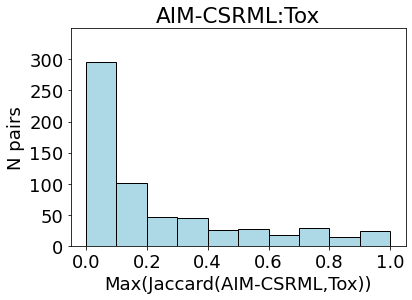

In [21]:
#df_2 = pd.read_pickle(processed_dir+'aim_tox_clean_compare.pkl')

plot_comparison(df_2,'TP/(TP+FP+FN) (Jaccard)','1')


Skipped due to no presence within dataset: 41
0.28560262264874897
(688,)


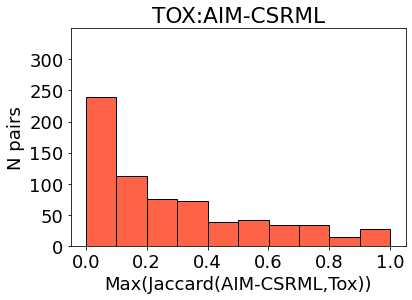

In [22]:
plot_comparison(df_2,'TP/(TP+FP+FN) (Jaccard)','2',True)


469